# Light Detection and Classification


CREDITS: Tensorflow Object Detection API documentation - https://github.com/tensorflow/models/tree/master/object_detection

# Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
from time import time

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

The current model is "SSD with Inception" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '../tl_data_sim/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '../tl_data/tl_label_map.pbtxt'

NUM_CLASSES = 1

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `1`, we know that this corresponds to `traffic light`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection

In [7]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images_sim'
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_OUTPUT_DIR = 'test_images_sim_out'

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

if not os.path.exists(TEST_OUTPUT_DIR):
    os.makedirs(TEST_OUTPUT_DIR)

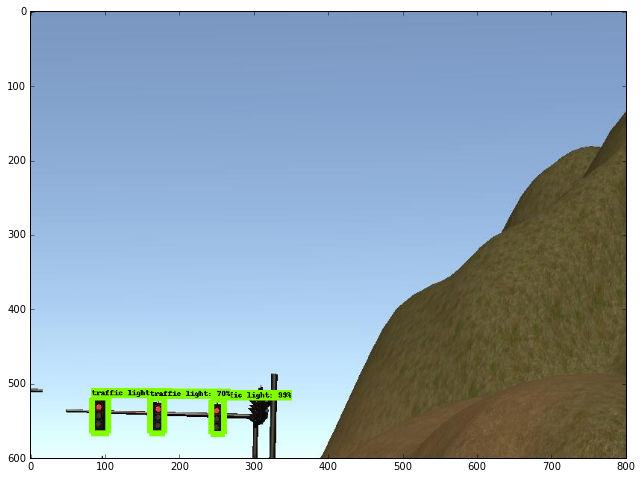

red area nonzero density:  0.222222222222
yellow area nonzero density:  0.0962962962963
green area nonzero density:  0.037037037037
light color: RED


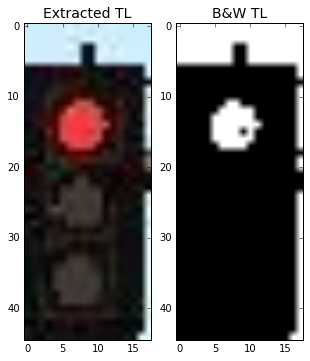

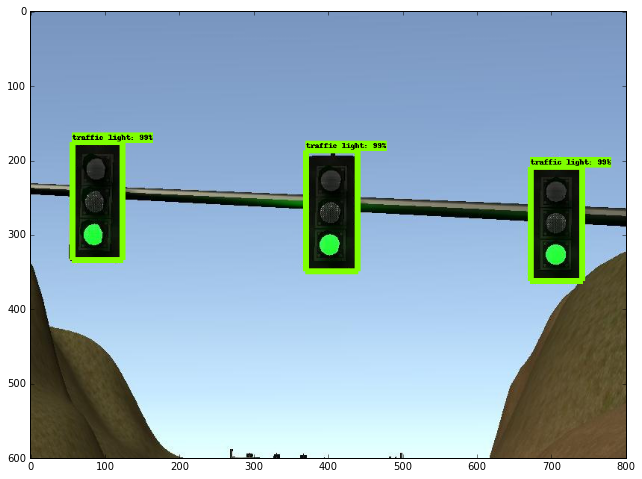

red area nonzero density:  0.00985090521832
yellow area nonzero density:  0.0103833865815
green area nonzero density:  0.165335463259
light color: GREEN


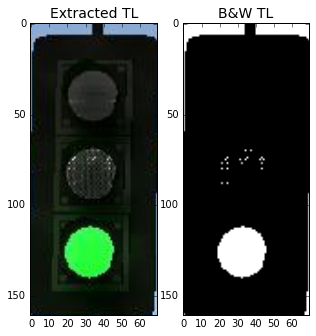

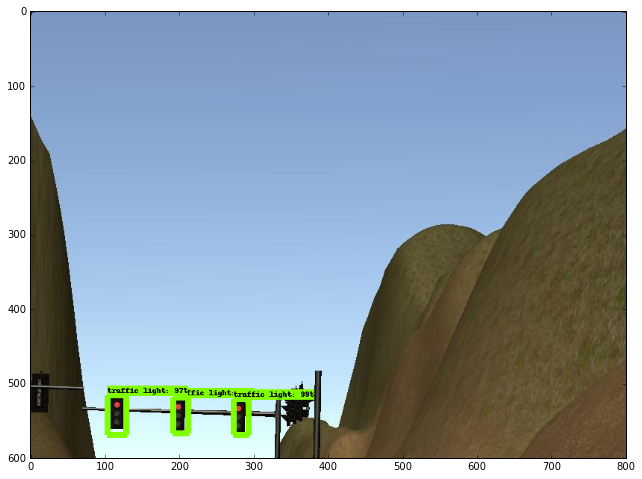

red area nonzero density:  0.234042553191
yellow area nonzero density:  0.173252279635
green area nonzero density:  0.16717325228
light color: RED


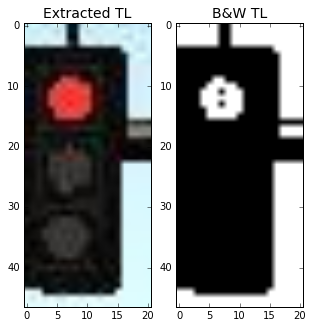

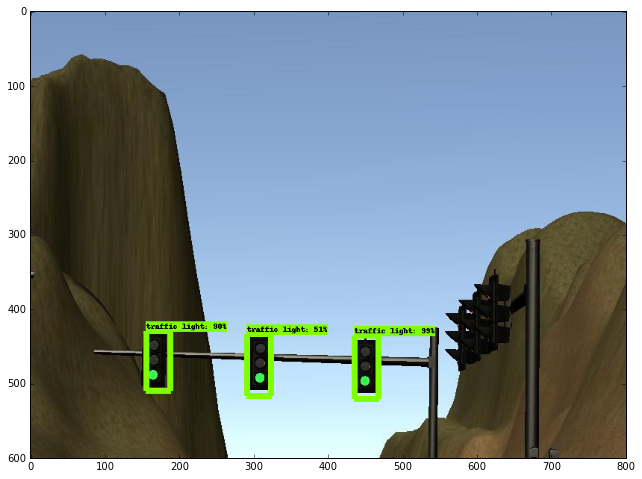

red area nonzero density:  0.0400432900433
yellow area nonzero density:  0.0508658008658
green area nonzero density:  0.166666666667
light color: GREEN


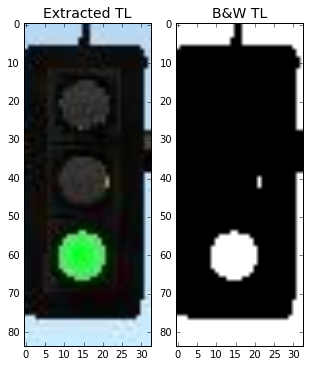

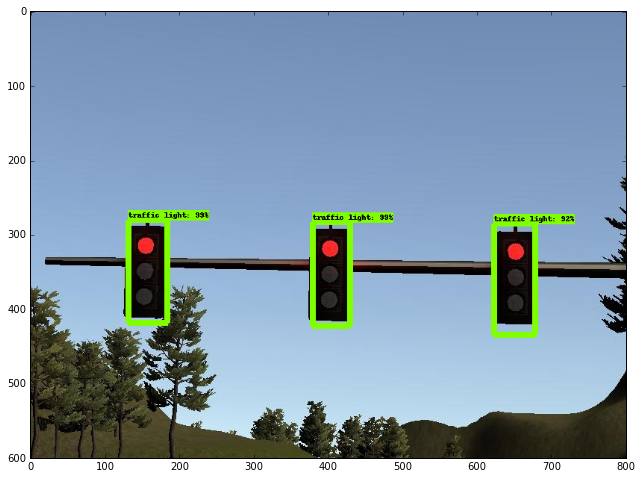

red area nonzero density:  0.128512396694
yellow area nonzero density:  0.0194214876033
green area nonzero density:  0.0219008264463
light color: RED


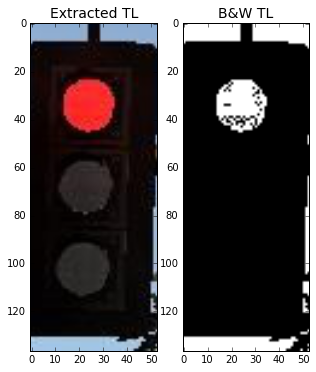

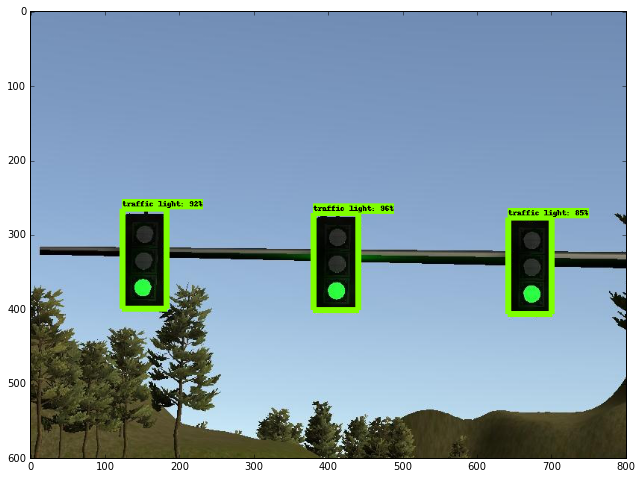

red area nonzero density:  0.0526115135341
yellow area nonzero density:  0.0362180709112
green area nonzero density:  0.192908882958
light color: GREEN


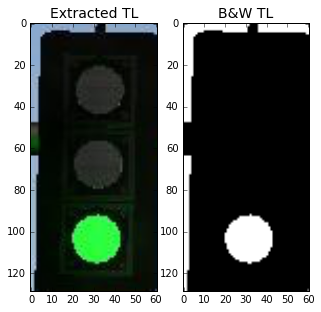

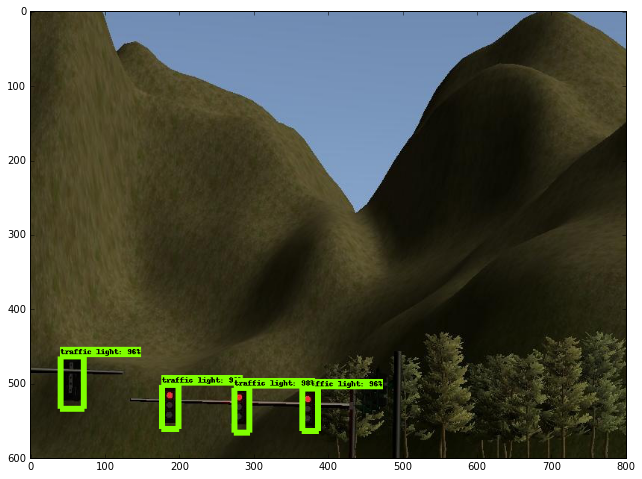

red area nonzero density:  0.0968468468468
yellow area nonzero density:  0.0045045045045
green area nonzero density:  0.0
light color: RED


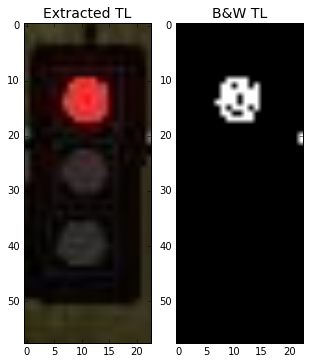

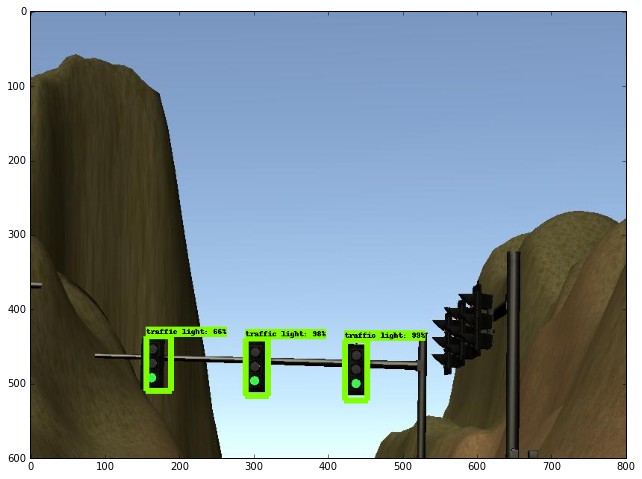

red area nonzero density:  0.0217917675545
yellow area nonzero density:  0.0266343825666
green area nonzero density:  0.141646489104
light color: GREEN


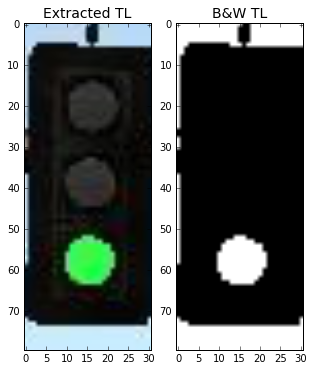

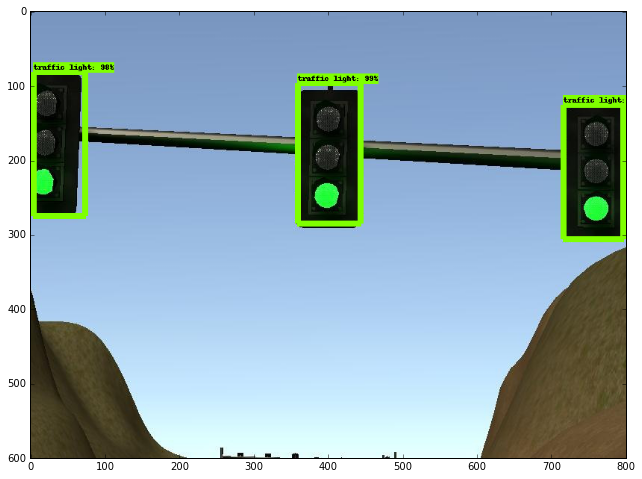

red area nonzero density:  0.0217063042658
yellow area nonzero density:  0.016798791997
green area nonzero density:  0.174594186485
light color: GREEN


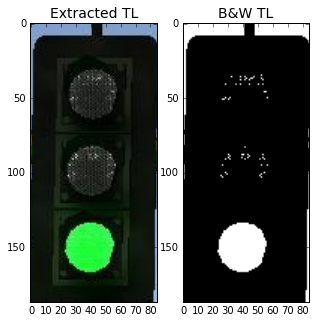

In [8]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = np.array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
        
      # print 'image path: ', image_path 
        
      start = time()
        
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
          
      # print 'runtime: ', time() - start, 's'
                
      boxes_new = np.squeeze(boxes)
      scores_new = np.squeeze(scores)
      min_score_thresh=.5
      image_np_new = image_np.copy()
      image_new = Image.fromarray(image_np_new)
      im_width, im_height = image_new.size
    
      found_box = False # limit to 1 traffic light

      boxes_new_shape = boxes_new.shape
    
      for i in range(boxes_new_shape[0]):
        if scores_new[i] > min_score_thresh and not found_box:
         
          # print 'score: ', scores_new[i]
            
          found_box = True
            
          ymin = boxes_new[i,0]
          xmin = boxes_new[i,1]
          ymax = boxes_new[i,2]
          xmax = boxes_new[i,3]
          (left, right, top, bottom) = (int(xmin * im_width), int(xmax * im_width),
                                  int(ymin * im_height), int(ymax * im_height))
          img_light = image_np_new[top:bottom,left:right]
 
          img_light_new = Image.fromarray(img_light)
          gray = img_light_new.convert('L')
            
          bw = np.asarray(gray).copy()
        
          bw[bw < 100] = 0    # Black
          bw[bw >= 100] = 255 # White
          imfile = Image.fromarray(bw)
          w, h = imfile.size
            
          h_w_ratio = h / (w * 1.0)            
    
          light_colors = [] #red, yellow, green
          single_light_pixel_count = int(h * w / 3)

          nzCountRed = np.count_nonzero(np.array(imfile)[int(h/10):int(h/3),:]) / (single_light_pixel_count * 1.0)
          nzCountYellow = np.count_nonzero(np.array(imfile)[int(h/3):int(h*2/3),:]) / (single_light_pixel_count * 1.0)
          nzCountGreen = np.count_nonzero(np.array(imfile)[int(h*2/3):int(h*9/10),:]) / (single_light_pixel_count * 1.0)
     
          light_colors.extend([nzCountRed, nzCountYellow, nzCountGreen])
        
          max_i = max(enumerate(light_colors),key=lambda x: x[1])[0]
    
          # Visualization of the results of a detection.
          vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
    
          plt.figure(figsize=IMAGE_SIZE)
          plt.imshow(image_np)
          plt.show()   
            
          f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,10))
          ax1.imshow(img_light)
          ax1.set_title('Extracted TL', fontsize=14)
          ax2.imshow(imfile, cmap='gray')
          ax2.set_title('B&W TL', fontsize=14)
            
          print 'red area nonzero density: ', nzCountRed
          print 'yellow area nonzero density: ', nzCountYellow
          print 'green area nonzero density: ', nzCountGreen
        
          if light_colors[max_i] > 0.05:
            if max_i == 0:
                print 'light color: RED'
            elif max_i == 1:
                print 'light color: YELLOW'
            elif max_i == 2:
                print 'light color: GREEN'
          else:
            print 'light color: UNKNOWN'
        
      image_out = Image.fromarray(image_np)
      image_out.save(os.path.join(TEST_OUTPUT_DIR, os.path.splitext(os.path.split(image_path)[1])[0] + '.jpg'))
      
        

